In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install deepxde
import re

import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from matplotlib import cm
import scipy.io

## Safety PDE with data

In [ ]:
import scipy.io

# mat = scipy.io.loadmat('/content/drive/MyDrive/RL+PDE/data/observe_x_dim100_MC_100.mat')
# mat = scipy.io.loadmat('/content/drive/MyDrive/RL+PDE/data/observe_x_dim100_MC_100_001.mat')  # Q scaled by 0.01
mat = scipy.io.loadmat('/content/drive/MyDrive/RL+PDE/data/observe_x_1kd_MC_1000.mat')  # Q scaled by 0.001
# mat = scipy.io.loadmat('/content/drive/MyDrive/RL+PDE/data/observe_x_3d_MC_1000.mat')
# mat = scipy.io.loadmat('/content/drive/MyDrive/RL+PDE/data/observe_x_3d_MC_10.mat')
# mat = scipy.io.loadmat('/content/drive/MyDrive/RL+PDE/data/observe_x_3d_MC_100.mat')
# mat = scipy.io.loadmat('/content/drive/MyDrive/RL+PDE/data/observe_x_3d_GT_cont.mat')

obs_x = mat['observe_x']
obs_func = mat['observe_func']

# obs_x.shape # (1500, 3)
# obs_func.shape # (1500, 1)

Text(0.5, 0.92, 'Riccati ')

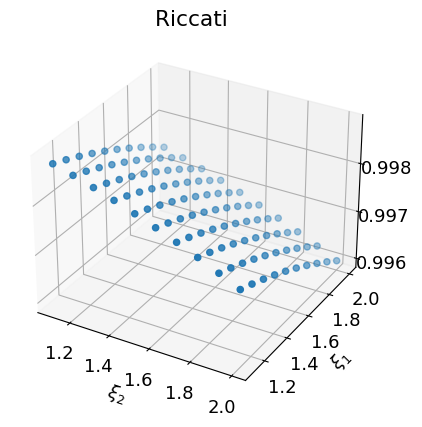

In [ ]:
a = 1400
b = 1500

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.scatter(obs_x[a:b,1], obs_x[a:b,0], obs_func[a:b]) # X: time, Y: state
ha.set_xlabel(r'$\xi_2$')
ha.set_ylabel(r'$\xi_1$')
ha.set_title("Riccati ")

In [ ]:
obs_x[a:b,2]

array([1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5])

In [ ]:
# ic = np.mgrid[1:8:0.05, 1:4:0.05, 1.5:1.45:-0.1].reshape(3,-1).T
ic = np.mgrid[1:2:0.05, 1:2:0.05, 1.5:1.45:-0.1].reshape(3,-1).T
ic
(0.5*ic[:,0]**2 + 0.5*ic[:,1]**2) * 0.1
np.exp(0.1*(-0.5*ic[:,0]**2 - 0.5*ic[:,1]**2))
ic.shape # (8400, 3)
# ic_func = np.exp(0.1*(-0.5*ic[:,0]**2 - 0.5*ic[:,1]**2))
ic_func = np.exp(0.001*(-0.5*ic[:,0]**2 - 0.5*ic[:,1]**2)) # Q scaled by 0.001
ic_func = ic_func.reshape(-1,1)
ic_func.shape # (8400, 1)

a = 1000
b = 1500

observe_x = np.append(obs_x[a:b], ic, axis=0)
# observe_x = ic
observe_x.shape # (9900, 3)
# observe_x

observe_func = np.append(obs_func[a:b], ic_func, axis=0)
# observe_func = ic_func
observe_func

array([[0.7605434 ],
       [0.78513938],
       [0.73674122],
       [0.75611431],
       [0.75194259],
       [0.73876829],
       [0.76469454],
       [0.76395192],
       [0.77222294],
       [0.7476901 ],
       [0.7649491 ],
       [0.76101879],
       [0.77374211],
       [0.73984115],
       [0.74346182],
       [0.75128982],
       [0.807396  ],
       [0.78081706],
       [0.76557076],
       [0.75000744],
       [0.7594498 ],
       [0.7544345 ],
       [0.73950548],
       [0.77473503],
       [0.75186755],
       [0.76929655],
       [0.7944769 ],
       [0.78237939],
       [0.77164423],
       [0.72057317],
       [0.78032962],
       [0.78148759],
       [0.80002949],
       [0.76856421],
       [0.76563032],
       [0.7319106 ],
       [0.7582288 ],
       [0.74253678],
       [0.74410616],
       [0.75002229],
       [0.74611288],
       [0.72385165],
       [0.77408705],
       [0.77342035],
       [0.75014416],
       [0.770259  ],
       [0.75897746],
       [0.753

### Fixed PDE

In [ ]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=2)
    dy_x1 = dde.grad.jacobian(y, x, j=0)
    dy_xx1 = dde.grad.hessian(y, x, i=0)
    dy_x2 = dde.grad.jacobian(y, x, j=1)
    dy_xx2 = dde.grad.hessian(y, x, i=1, j=1)
    # Backend tensorflow.compat.v1 or tensorflow
    return (
        dy_t
        + x[:, 0:1] * dy_x1
        + x[:, 1:2] * dy_x2
        + 250 * dy_xx1
        + 250 * dy_xx2
        - 0.001*(0.5*x[:, 0:1]**2 + 0.5*x[:, 1:2]**2) * y
    )

### Varying PDE

In [ ]:
observe_y = dde.icbc.PointSetBC(observe_x, observe_func, component=0)

geom = dde.geometry.geometry_2d.Rectangle([1,1],[2,2])
timedomain = dde.geometry.TimeDomain(0, 1.5)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [observe_y],
    # num_domain=0,
    num_domain=800,
    # num_boundary=20,
    # num_initial=10,
    anchors=observe_x,
)

In [ ]:
layer_size = [3] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile(
    "adam", lr=0.001, external_trainable_variables=[]
)
variable = dde.callbacks.VariableValue([], period=1000)
model.train(epochs=60000, callbacks=[variable])

Compiling model...
Building feed-forward neural network...
'build' took 0.055620 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.683499 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.76e+03, 8.64e-01]    [1.76e+03, 8.64e-01]    []  
0 []
1000      [5.82e-02, 6.31e-03]    [5.82e-02, 6.31e-03]    []  
1000 []
2000      [1.81e-02, 5.62e-03]    [1.81e-02, 5.62e-03]    []  
2000 []
3000      [6.75e-03, 5.16e-03]    [6.75e-03, 5.16e-03]    []  
3000 []
4000      [3.52e-03, 4.78e-03]    [3.52e-03, 4.78e-03]    []  
4000 []
5000      [2.06e-03, 4.35e-03]    [2.06e-03, 4.35e-03]    []  
5000 []
6000      [1.15e-03, 3.79e-03]    [1.15e-03, 3.79e-03]    []  
6000 []
7000      [6.18e-03, 3.29e-03]    [6.18e-03, 3.29e-03]    []  
7000 []
8000      [5.37e-04, 2.88e-03]    [5.37e-04, 2.88e-03]    []  
8000 []
9000      [4.36e-04, 2.56e-03]    [4.36e-04, 2.56e-03]    []  
9000 []
10000     [1.06e-02, 2.34e-03]    [1.06e-02, 2.34e-03]    []  
10000 []
11000     [3.44e-04, 2.10e-03]    [3.44e-04, 2.10e-03]    []  
11000 []
12000     [3.07e-04, 1.97e-03]   

(<deepxde.model.LossHistory at 0x7d369c168ac0>,
 <deepxde.model.TrainState at 0x7d369c0eb3a0>)

In [ ]:
import scipy.io

mat0 = scipy.io.loadmat('/content/drive/MyDrive/RL+PDE/data/observe_x_1kd_10e5.mat') # Q scaled by 0.001

obs0_x = mat0['observe_x']
obs0_func = mat0['observe_func']

In [ ]:
test_x = obs0_x
test_x.shape

yhat = model.predict(test_x)

yhat.shape

difference = yhat - obs0_func

In [ ]:
# np.save('prediction_dim_1k.npy', yhat)

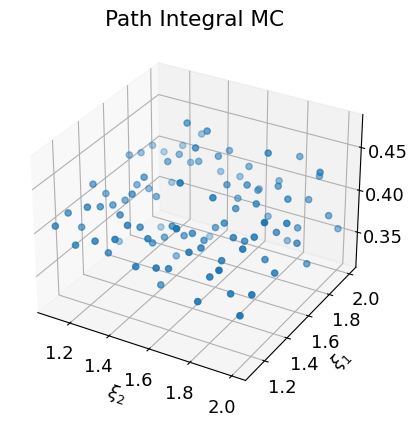

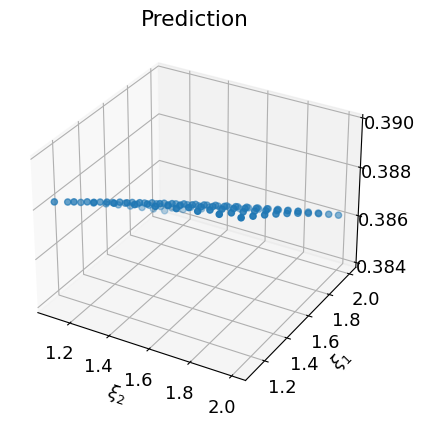

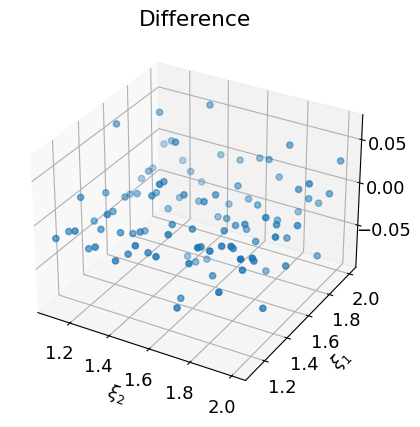

In [ ]:
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.scatter(obs0_x[a:b,1], obs0_x[a:b,0], obs_func[a:b]) # X: time, Y: state
ha.set_xlabel(r'$\xi_2$')
ha.set_ylabel(r'$\xi_1$')
ha.set_title("Path Integral MC")
plt.savefig("Path Integral MC.pdf")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.scatter(obs0_x[a:b,1], obs0_x[a:b,0], yhat[a:b]) # X: time, Y: state
ha.set_xlabel(r'$\xi_2$')
ha.set_ylabel(r'$\xi_1$')
ha.set_title("Prediction")
plt.savefig("Prediction.pdf")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.scatter(obs0_x[a:b,1], obs0_x[a:b,0], yhat[a:b]-obs_func[a:b]) # X: time, Y: state
ha.set_xlabel(r'$\xi_2$')
ha.set_ylabel(r'$\xi_1$')
ha.set_title("Difference")
plt.savefig("Difference.pdf")
plt.show()